In [1]:
import pandas as pd
import numpy as np; np.random.seed(0)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys

feature_files = ['SP500', 'Gold', 'WTI', 'US10Y', 'BDI', 'Bitcoin'] 
target_file = 'DXY'

In order to predict US Dollar Index, **I choose the following features: S&P 500 Index(SP500), Gold Price (Gold), Crude Oil WTI(WTI), US 10-Year Bond Yield(US10Y), Baltic Dry Index(BDI), and the price of Bitcoin (Bitcoin).** I use the historical data from 01/01/2018 to 7/26/2019. Why do I choose these features? S&P 500 Index is an indicator of investors' behavior. Gold price and Cruid Oil price are both in US Dollar, so I guess it might have some linear or nonlinear relationship with US Dollar Index. US 10-Year Bond Yield reflects how investors feel about the economy and also the Fed's attitude on monetary policy. Baltic Dry Index give people insight into global supply and demand trends, so it's a leading economic indicator. Bitcoin is also a form of currency. I guess it might have some similiar trend with US Dollar Index.

In [2]:
for n, f in enumerate([target_file]+feature_files):
    df_tmp = pd.read_csv(f+'.csv', sep = ',', thousands = ',', header = 0, index_col = 0)
    df_tmp = df_tmp.drop('Change %', axis = 1)
    try:
        df_tmp = df_tmp.drop('Vol.', axis = 1)
    except:
        pass
    df_tmp.index = pd.to_datetime(df_tmp.index)
    df_tmp.columns = ['Price-'+f, 'Open-'+f, 'high-'+f, 'low-'+f]    
    if n == 0:
        df = df_tmp
    else:
        df = df.join(df_tmp)

By using for loop, we can combine all dataset into one. Since every feature file has columns of price, open, high, and low, I add the name of each feature file at the end.

In [3]:
df = df.interpolate(method='linear')
df = df.iloc[::-1]

There are some missing value in the dataset, so I use interpolation to replace the missing values. Replacing missing value is not necessary in Random Forest model.

In [10]:
def timeseries_to_array(df, history_steps = 5):
    for n in range(df.shape[0]-history_steps):  
        step_features = df.iloc[n:n+history_steps,:].values.flatten().reshape((1,-1))
        step_target = df.iloc[n+history_steps, 0]
        if n == 0:
            feature_array = step_features
            target_array = [step_target]
        else:
            feature_array = np.concatenate((feature_array, step_features), axis = 0)
            target_array.append(step_target)

    return feature_array, np.array(target_array)

print('df.shape', df.shape)
x_train, y_train = timeseries_to_array(df.iloc[:-50,:], 5)
x_test, y_test = timeseries_to_array(df.iloc[-50:,:], 5)
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

df.shape (411, 28)
x_train.shape (356, 140)
y_train.shape (356,)
x_test.shape (45, 140)
y_test.shape (45,)


The target is to predict the US Dollar Index. The first column is our target, and the rest columns are features.The original data set has 28 columns and 411 rows. Base on the concept of autoregression, I uses observations from previous 5 days as input to predict the value at the next step. So there are total of 140 features (28/per day x 5 days). I use the data to predict the latest 50 days of US Dollar Index. 

In [9]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = 1.0, oob_score = True, verbose = 0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('oob_score', model.oob_score_)
print('mse root:', np.sqrt(np.mean(np.square(y_test-y_pred))))

oob_score 0.9809455670400115
mse root: 0.7501881332877485


Oob score is to estimate the generalization accuracy by using out-of-bag samples. **The oob score is 0.98, which is really good.** 

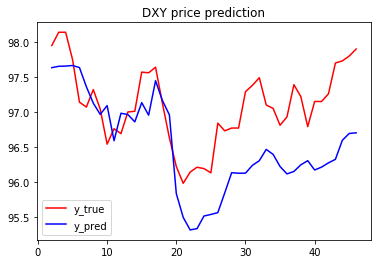

In [13]:
plt.figure(0)
plt.plot(list(range(2,len(y_pred)+2)), y_test,'r', list(range(2,len(y_pred)+2)), y_pred, 'b')
#plt.xticks(ticks = np.arange(2,27,2))
plt.legend(['y_true', 'y_pred'])
plt.title(target_file+' price prediction')
plt.savefig('predict.png')



THe first graph shows the trend of prediction and the real data. The performance is really good. 

<Figure size 432x288 with 0 Axes>

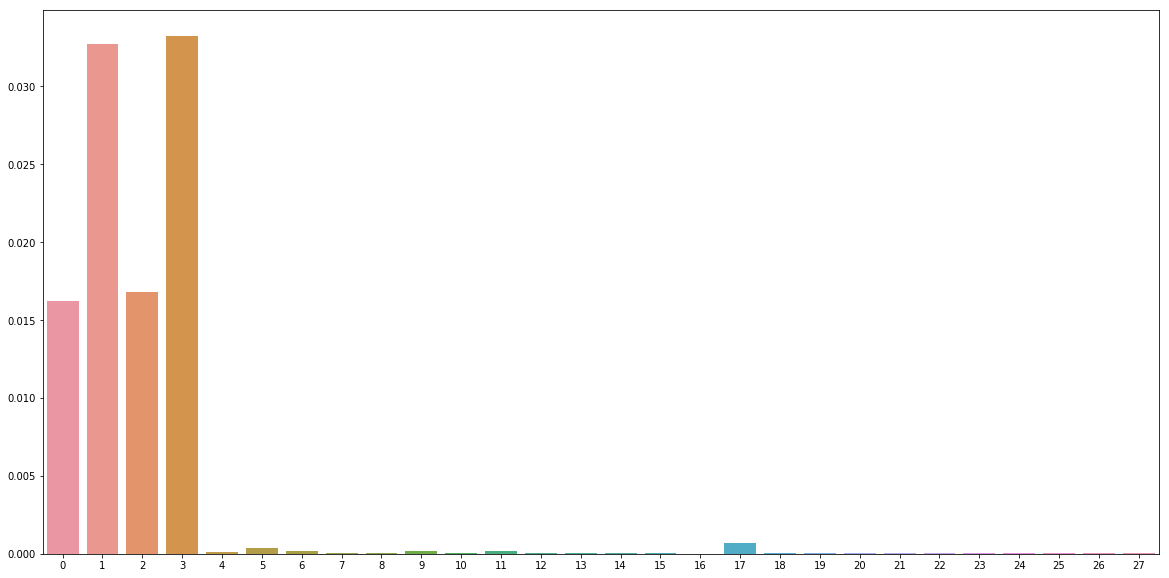

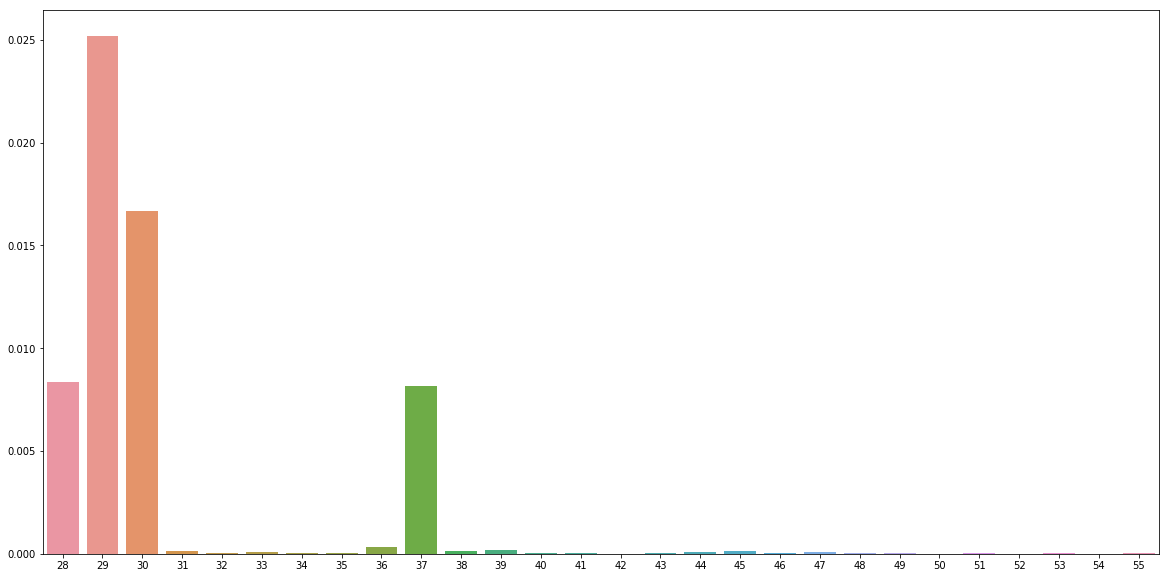

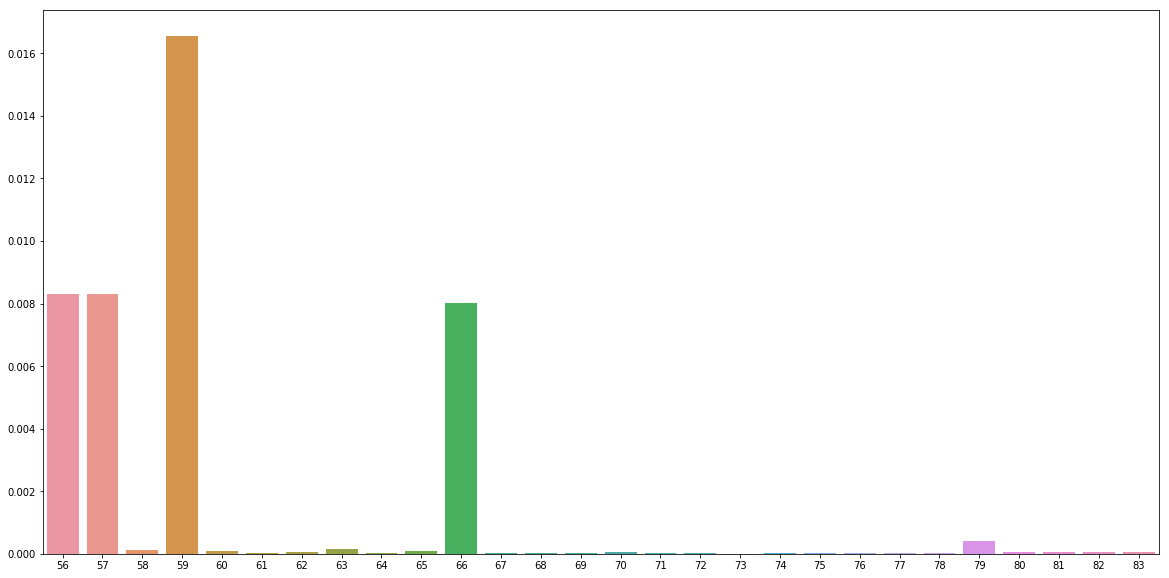

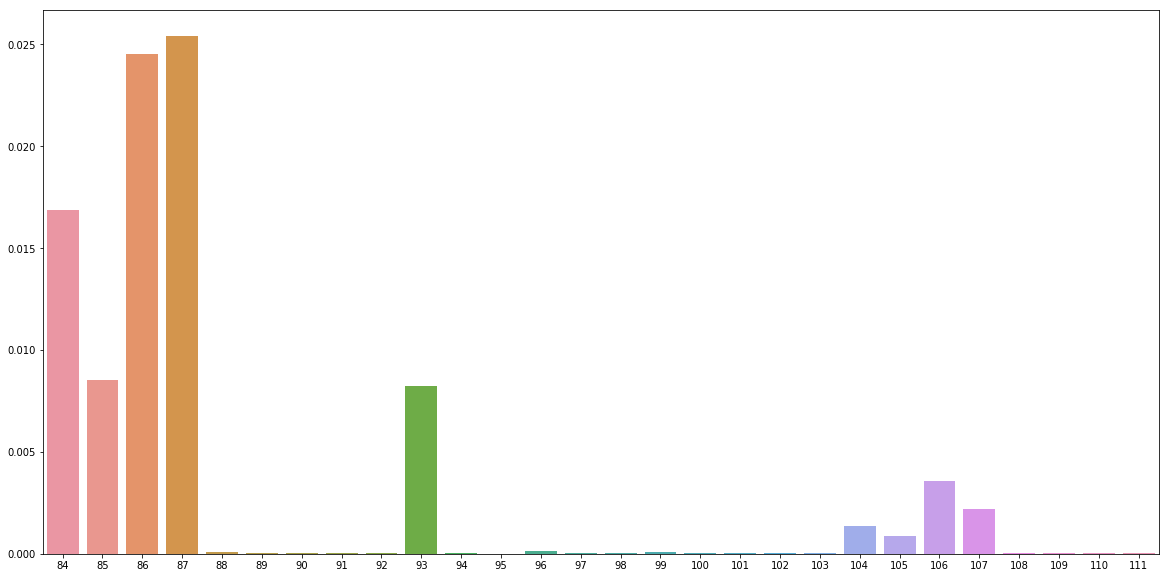

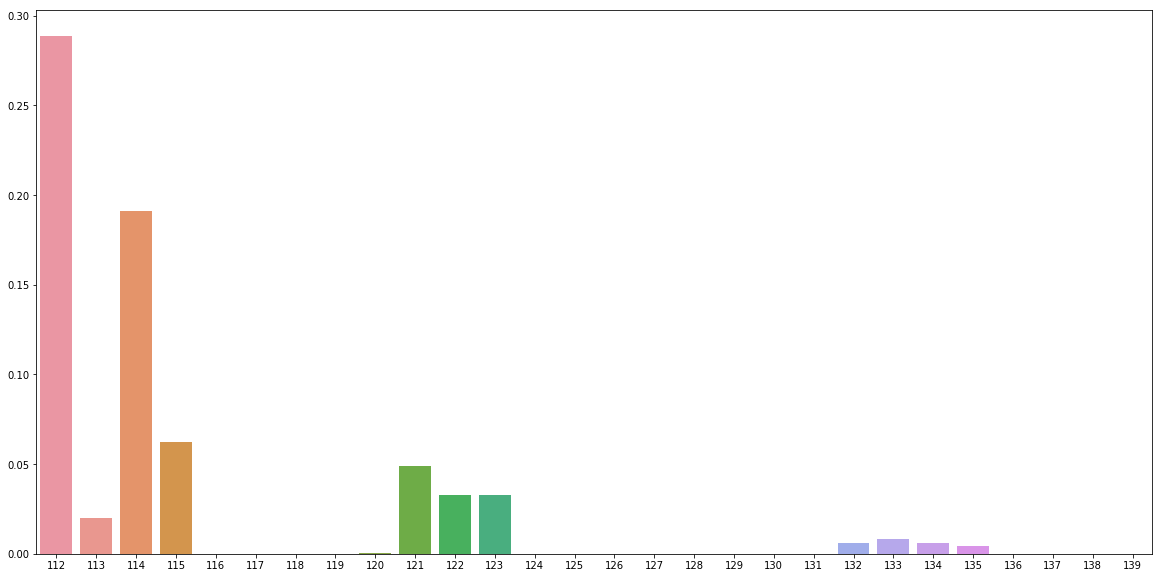

In [12]:
tot_file = len(feature_files+[target_file])
for n in range(5):
    plt.figure(n+1)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=np.arange(tot_file*4*n, tot_file*4*(n+1)), 
                y=model.feature_importances_[tot_file*4*n:tot_file*4*(n+1)])
plt.show()

Based on Random Forest Model, it can generate the feature importance. Among the 140 features, the most important features are the related to the previous US Dollar Index, which is very reasonable. But the features relating to Gold Price and Baltic Dry Index also shows some importances, which really surprising. 